**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

import matplotlib.pyplot as plt

from collections import defaultdict

## Import data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# define directory path
directory = "drive/MyDrive/Progetto Data Mining 2/CODICE PROGETTO/Time Series/DATASET/"
df = pd.read_csv("drive/MyDrive/Progetto Data Mining 2/DATASET/RavdessAudioOnlyFeatures_TRAIN.csv")

# import ts data
df_train = pd.read_csv(directory + "Approximated/ts_data_TRAIN_PAA.csv", index_col="Unnamed: 0")
df_test = pd.read_csv(directory + "Approximated/ts_data_TEST_PAA.csv", index_col="Unnamed: 0")

df_train_100 = pd.read_csv(directory + "Approximated/ts_data_TRAIN_100_PAA.csv", index_col="Unnamed: 0")
df_test_100 = pd.read_csv(directory + "Approximated/ts_data_TEST_100_PAA.csv", index_col="Unnamed: 0")


# get ts values
X_train = df_train.values
X_test = df_test.values

X_train_100 = df_train_100.values
X_test_100 = df_test_100.values

# import emotion data
y_train = pd.read_csv(directory + "RavdessAudioOnlyNumpy__Y_train.csv")["emotion"]
y_test = pd.read_csv(directory + "RavdessAudioOnlyNumpy__Y_test.csv")["emotion"]

# check length
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)


In [4]:
# Filter the original DataFrame for speech (1) or song (2)
df_song = df[df["vocal_channel"] == "song"]

# Get the indices of speech and song rows
song_indices = df_song.index

# Filter the time series DataFrames and target variable for speech and song
X_train = df_train.loc[song_indices].values

X_train_100 = df_train_100.loc[song_indices].values

y_train = y_train.loc[song_indices].values

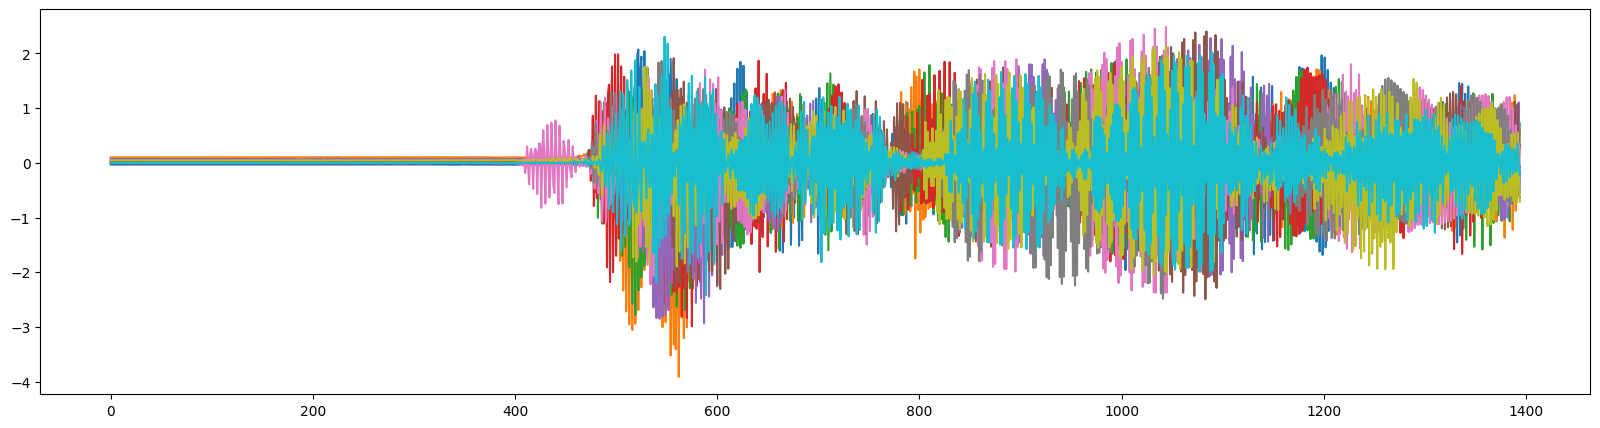

In [5]:
# plot the audio wave
plt.figure(figsize=(20,5))

for ts in X_train[:10]:
  plt.plot(ts)

plt.show()

In [6]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 7.8 MB/s eta 0:00:00


##Baseline

In [7]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_clf.predict(X_test)

dummy_clf.score(X_test, y_test)

0.15384615384615385

# Shaplet Classifiers

In [8]:
# Learning-based Approach

In [9]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

In [11]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 748
ts_sz 1395
n_classes 6
shapelet_sizes {139: 6}


In [12]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=100,
                        verbose=1)

/usr/local/lib/python3.10/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [13]:
shp_clf.fit(X_train, y_train)

Epoch 1/100
3/3 [==============================] - 12s 78ms/step - loss: 2.2445 - categorical_accuracy: 0.1711 - categorical_crossentropy: 2.1679
Epoch 2/100
3/3 [==============================] - 0s 25ms/step - loss: 2.2304 - categorical_accuracy: 0.1711 - categorical_crossentropy: 2.1542
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 2.2169 - categorical_accuracy: 0.1658 - categorical_crossentropy: 2.1412
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 2.2038 - categorical_accuracy: 0.1644 - categorical_crossentropy: 2.1285
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 2.1913 - categorical_accuracy: 0.1644 - categorical_crossentropy: 2.1162
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 2.1789 - categorical_accuracy: 0.1644 - categorical_crossentropy: 2.1043
Epoch 7/100
3/3 [==============================] - 0s 18ms/step - loss: 2.1672 - categorical_accuracy: 0.1684 - categorical_cross

LearningShapelets(max_iter=100, n_shapelets_per_size={139: 6}, verbose=1,
                  weight_regularizer=0.01)

In [14]:
y_pred = shp_clf.predict(X_test)

3/3 [==============================] - 0s 49ms/step


In [15]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division=0, labels=np.unique(y_pred)))

Accuracy 0.16346153846153846
F1-score [0.07142857 0.27543036 0.         0.03603604 0.05309735 0.
 0.07751938 0.        ]
              precision    recall  f1-score   support

       angry       0.25      0.04      0.07        96
        calm       0.16      0.92      0.28        96
     fearful       0.13      0.02      0.04        96
       happy       0.18      0.03      0.05        96
         sad       0.15      0.05      0.08        96

   micro avg       0.16      0.21      0.18       480
   macro avg       0.17      0.21      0.10       480
weighted avg       0.17      0.21      0.10       480



In [16]:
predict_proba_dist = shp_clf.predict_proba(X_test)

3/3 [==============================] - 0s 18ms/step


In [17]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [18]:
pred_probability = []
for eachArr in predict_proba_dist:
    pred_probability.append(softmax(eachArr))

In [19]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()


In [20]:
y_test_encoded = lb.fit_transform(y_test)


In [21]:
from sklearn.metrics import roc_auc_score
print('ROC-AUC %s' % roc_auc_score(y_test_encoded, pred_probability, multi_class="ovr"))


ROC-AUC 0.5504124359918631


# Shaplet-distances-based Classifier

In [15]:
X_train2 = shp_clf.transform(X_train)

3/3 [==============================] - 0s 21ms/step


In [16]:
X_train2.shape

(748, 6)

In [17]:
X_train2

array([[1.9202093e+00, 1.2472766e-03, 1.2120301e+00, 8.5414463e-01,
        1.5085931e+00, 1.5377506e+00],
       [1.8951674e+00, 9.6820341e-03, 1.1911323e+00, 7.3637038e-01,
        1.5219121e+00, 1.2065105e+00],
       [1.9062165e+00, 9.3443983e-04, 1.2098030e+00, 8.7728155e-01,
        1.5091090e+00, 1.5572286e+00],
       ...,
       [1.0123564e+00, 1.1755888e-03, 7.0527309e-01, 4.7253221e-01,
        6.5778446e-01, 5.8426279e-01],
       [1.4865962e+00, 2.2636767e-04, 9.6369243e-01, 4.6432215e-01,
        9.4864583e-01, 8.3804947e-01],
       [8.3102548e-01, 2.7493507e-04, 5.5296469e-01, 4.4024375e-01,
        6.7858559e-01, 5.1508933e-01]], dtype=float32)

In [18]:
X_test2 = shp_clf.transform(X_test)

3/3 [==============================] - 0s 21ms/step


In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric="euclidean" )
clf.fit(X_train2, y_train)

KNeighborsClassifier(metric='euclidean')

In [21]:
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division=0, labels=np.unique(y_pred)))

Accuracy 0.15224358974358973
F1-score [0.19642857 0.27509294 0.         0.10810811 0.09356725 0.02105263
 0.16346154 0.        ]
              precision    recall  f1-score   support

       angry       0.17      0.23      0.20        96
        calm       0.21      0.39      0.28        96
     fearful       0.11      0.10      0.11        96
       happy       0.11      0.08      0.09        96
     neutral       0.02      0.02      0.02        48
         sad       0.15      0.18      0.16        96

   micro avg       0.15      0.18      0.16       528
   macro avg       0.13      0.17      0.14       528
weighted avg       0.14      0.18      0.15       528



In [ ]:
predict_proba_dist = clf.predict_proba(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

NameError: ignored

# Feature-based Classifier

In [22]:
import scipy.stats as stats

In [23]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [24]:
X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])

In [25]:
X_train3.shape

(748, 13)

In [26]:
X_train3

array([[-6.09550565e-05,  6.18978903e-01,  3.83134882e-01, ...,
        -9.84767918e-05,  2.35994896e-01,  1.39503512e+00],
       [ 4.68116713e-05,  6.70110757e-01,  4.49048426e-01, ...,
         6.98566182e-05, -1.38935670e+00,  5.15828534e+00],
       [ 2.17489103e-04,  6.31389297e-01,  3.98652445e-01, ...,
         3.44461182e-04, -4.87287438e-01,  2.30304711e+00],
       ...,
       [ 3.54302924e-04,  9.91692364e-01,  9.83453745e-01, ...,
         3.57271001e-04, -2.03975961e+00,  9.42568161e+00],
       [-2.32101805e-04,  9.80838040e-01,  9.62043260e-01, ...,
        -2.36636218e-04, -6.54394350e-01,  1.59965205e+01],
       [-2.75145383e-04,  9.70855296e-01,  9.42560005e-01, ...,
        -2.83405142e-04, -3.89209606e+00,  2.81334705e+01]])

In [27]:
X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])

In [28]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division=0, labels=np.unique(y_pred)))

Accuracy 0.20192307692307693
F1-score [0.2231405  0.22222222 0.         0.13605442 0.22857143 0.36363636
 0.20233463 0.        ]
              precision    recall  f1-score   support

       angry       0.18      0.28      0.22        96
        calm       0.18      0.28      0.22        96
     fearful       0.20      0.10      0.14        96
       happy       0.25      0.21      0.23        96
     neutral       0.40      0.33      0.36        48
         sad       0.16      0.27      0.20        96

   micro avg       0.20      0.24      0.22       528
   macro avg       0.23      0.25      0.23       528
weighted avg       0.21      0.24      0.22       528



In [29]:
predict_proba_dist = clf.predict_proba(X_test3)

In [30]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [31]:
pred_probability = []
for eachArr in predict_proba_dist:
    pred_probability.append(softmax(eachArr))

In [32]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()


In [33]:
y_test_encoded = lb.fit_transform(y_test)


In [34]:
from sklearn.metrics import roc_auc_score
print('ROC-AUC %s' % roc_auc_score(y_test_encoded, pred_probability, multi_class="ovr"))


ROC-AUC 0.4917819689955107


# Time Series Classifier

In [29]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric="euclidean" )
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
#print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division=0, labels=np.unique(y_pred)))

Accuracy 0.15224358974358973
F1-score [0.17894737 0.22626263 0.         0.1        0.11180124 0.0625
 0.08196721 0.        ]
              precision    recall  f1-score   support

       angry       0.18      0.18      0.18        96
        calm       0.14      0.58      0.23        96
     fearful       0.25      0.06      0.10        96
       happy       0.14      0.09      0.11        96
     neutral       0.12      0.04      0.06        48
         sad       0.19      0.05      0.08        96

   micro avg       0.15      0.18      0.16       528
   macro avg       0.17      0.17      0.13       528
weighted avg       0.18      0.18      0.13       528



In [ ]:
predict_proba_dist = clf.predict_proba(X_test)

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [ ]:
pred_probability = []
for eachArr in predict_proba_dist:
    pred_probability.append(softmax(eachArr))

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()


In [ ]:
y_test_encoded = lb.fit_transform(y_test)


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
print('ROC-AUC %s' % roc_auc_score(y_test_encoded, pred_probability, multi_class="ovr"))

ROC-AUC 0.5197044226992144


In [30]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division=0, labels=np.unique(y_pred)))

Accuracy 0.17147435897435898
F1-score [0.23041475 0.20242915 0.         0.13       0.1595092  0.10810811
 0.21513944 0.        ]
              precision    recall  f1-score   support

       angry       0.21      0.26      0.23        96
        calm       0.17      0.26      0.20        96
     fearful       0.12      0.14      0.13        96
       happy       0.19      0.14      0.16        96
     neutral       0.15      0.08      0.11        48
         sad       0.17      0.28      0.22        96

   micro avg       0.17      0.20      0.19       528
   macro avg       0.17      0.19      0.17       528
weighted avg       0.17      0.20      0.18       528



In [ ]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.5 MB/s eta 0:00:00


In [ ]:
from pyts.classification import KNeighborsClassifier

In [ ]:
#USO IL DATASET RIDOTTO PERCHE' IMPIEGA TROPPO TEMPO CON L'ORIGINALE
clf = KNeighborsClassifier(metric='dtw_sakoechiba')
clf.fit(X_train_100, y_train)

y_pred = clf.predict(X_test_100)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.1907051282051282
F1-score [0.24444444 0.24561404 0.1372549  0.14130435 0.19626168 0.10526316
 0.22335025 0.15238095]
              precision    recall  f1-score   support

       angry       0.26      0.23      0.24        96
        calm       0.28      0.22      0.25        96
     disgust       0.13      0.15      0.14        48
     fearful       0.15      0.14      0.14        96
       happy       0.18      0.22      0.20        96
     neutral       0.11      0.10      0.11        48
         sad       0.22      0.23      0.22        96
   surprised       0.14      0.17      0.15        48

    accuracy                           0.19       624
   macro avg       0.18      0.18      0.18       624
weighted avg       0.20      0.19      0.19       624



# CNN Classifier

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization

In [36]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()

    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [37]:
from sklearn.model_selection import train_test_split
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  1395
N. LABELS:  6


In [38]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_cnn = encoder.fit_transform(y_train_cnn)
y_val_cnn = encoder.fit_transform(y_val_cnn)
y_test = encoder.fit_transform(y_test)

y_val_cnn


array([3, 3, 2, 1, 1, 3, 2, 4, 1, 0, 0, 1, 5, 2, 0, 2, 2, 3, 5, 3, 2, 1,
       1, 1, 3, 0, 1, 0, 1, 3, 5, 5, 5, 0, 5, 0, 0, 1, 3, 5, 4, 1, 1, 4,
       3, 0, 2, 5, 5, 2, 3, 3, 3, 2, 2, 2, 5, 1, 0, 5, 1, 0, 2, 5, 2, 5,
       5, 0, 3, 2, 5, 4, 3, 0, 1, 1, 0, 0, 4, 4, 3, 3, 5, 5, 1, 3, 3, 5,
       0, 3, 1, 2, 4, 1, 1, 1, 0, 2, 1, 5, 2, 4, 3, 2, 3, 2, 2, 0, 2, 0,
       3, 0, 5, 1, 2, 4, 3, 1, 4, 1, 3, 5, 4, 0, 2, 1, 4, 5, 4, 4, 5, 3,
       0, 2, 0, 1, 5, 2, 5, 3, 0, 2, 3, 1, 0, 5, 2, 5, 0, 0])

In [39]:
cnn = build_simple_cnn(n_timesteps, n_outputs)

In [40]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1388, 16)          144       
                                                                 
 batch_normalization (BatchN  (None, 1388, 16)         64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1388, 16)          0         
                                                                 
 dropout (Dropout)           (None, 1388, 16)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1384, 32)          2592      
                                                                 
 batch_normalization_1 (Batc  (None, 1384, 32)         128       
 hNormalization)                                        

In [41]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [42]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

In [43]:
history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/5
38/38 [==============================] - 6s 20ms/step - loss: 1.7612 - accuracy: 0.2207 - val_loss: 1.7698 - val_accuracy: 0.1933 - lr: 0.0010
Epoch 2/5
38/38 [==============================] - 0s 11ms/step - loss: 1.6627 - accuracy: 0.2876 - val_loss: 1.7501 - val_accuracy: 0.1933 - lr: 0.0010
Epoch 3/5
38/38 [==============================] - 0s 10ms/step - loss: 1.6108 - accuracy: 0.3278 - val_loss: 1.7410 - val_accuracy: 0.2200 - lr: 0.0010
Epoch 4/5
38/38 [==============================] - 0s 10ms/step - loss: 1.5468 - accuracy: 0.3796 - val_loss: 1.7233 - val_accuracy: 0.2200 - lr: 0.0010
Epoch 5/5
38/38 [==============================] - 0s 13ms/step - loss: 1.5114 - accuracy: 0.3980 - val_loss: 1.7049 - val_accuracy: 0.2467 - lr: 0.0010


In [44]:
y_pred = np.argmax(cnn.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division=0, labels=np.unique(y_pred)))

20/20 [==============================] - 0s 4ms/step
Accuracy 0.1762820512820513
F1-score [0.29490617 0.26751592 0.03921569 0.04137931 0.         0.15929204
 0.         0.        ]
              precision    recall  f1-score   support

           0       0.20      0.57      0.29        96
           1       0.19      0.44      0.27        96
           2       0.33      0.02      0.04        48
           3       0.06      0.03      0.04        96
           4       0.00      0.00      0.00        96
           5       0.14      0.19      0.16        48

   micro avg       0.18      0.23      0.20       480
   macro avg       0.15      0.21      0.13       480
weighted avg       0.14      0.23      0.14       480



In [45]:
cnn.evaluate(X_test_cnn, y_test)

20/20 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.1763


[nan, 0.17628204822540283]

In [46]:
predict_proba_dist = clf.predict_proba(X_test)

ValueError: ignored

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [ ]:
pred_probability = []
for eachArr in predict_proba_dist:
    pred_probability.append(softmax(eachArr))

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()


In [ ]:
y_test_encoded = lb.fit_transform(y_test)


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
print('ROC-AUC %s' % roc_auc_score(y_test_encoded, pred_probability, multi_class="ovr"))

# LSTM Classifier

In [ ]:
from keras.layers import LSTM

In [ ]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
lstm = build_lstm(n_timesteps, n_outputs)

In [ ]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 281,160
Trainable params: 281,160
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/10
92/92 [==============================] - 1s 9ms/step - loss: 1.8694 - accuracy: 0.2750 - val_loss: 1.9143 - val_accuracy: 0.2596 - lr: 0.0010
Epoch 2/10
92/92 [==============================] - 1s 12ms/step - loss: 1.8584 - accuracy: 0.2722 - val_loss: 1.8931 - val_accuracy: 0.2760 - lr: 0.0010
Epoch 3/10
92/92 [==============================] - 1s 12ms/step - loss: 1.8401 - accuracy: 0.2914 - val_loss: 1.8868 - val_accuracy: 0.2760 - lr: 0.0010
Epoch 4/10
92/92 [==============================] - 1s 12ms/step - loss: 1.8233 - accuracy: 0.2948 - val_loss: 1.8601 - val_accuracy: 0.3115 - lr: 0.0010
Epoch 5/10
92/92 [==============================] - 1s 11ms/step - loss: 1.7940 - accuracy: 0.2907 - val_loss: 1.8428 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 6/10
92/92 [==============================] - 1s 8ms/step - loss: 1.7882 - accuracy: 0.3133 - val_loss: 1.8346 - val_accuracy: 0.3361 - lr: 0.0010
Epoch 7/10
92/92 [==============================] - 1s 8ms/step - loss: 1.7682

In [ ]:
y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 1s 30ms/step
Accuracy 0.13942307692307693
F1-score [0.         0.13636364 0.         0.18562874 0.         0.
 0.22166247 0.        ]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.15      0.12      0.14        96
           2       0.00      0.00      0.00        48
           3       0.13      0.32      0.19        96
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00        48
           6       0.15      0.46      0.22        96
           7       0.00      0.00      0.00        48

    accuracy                           0.14       624
   macro avg       0.05      0.11      0.07       624
weighted avg       0.07      0.14      0.08       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
lstm.evaluate(X_test_cnn, y_test)

20/20 [==============================] - 1s 27ms/step - loss: 2.0794 - accuracy: 0.1394


[2.07938289642334, 0.13942307233810425]

# Multivariate Time Series Classifiers

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
y_train.shape

(1828,)

In [ ]:
y_train

0         neutral
1         neutral
2         neutral
3         neutral
4            calm
          ...    
1823    surprised
1824    surprised
1825    surprised
1826    surprised
1827    surprised
Name: emotion, Length: 1828, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
print("Original X_train shape:", X_train.shape)
print("Original X_test shape:", X_test.shape)


Original X_train shape: (1828, 1395, 1)
Original X_test shape: (624, 1395, 1)


In [ ]:
num_train_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

time_steps = 45
features_per_step = 31

X_train_reshaped = X_train.reshape(num_train_samples, time_steps, features_per_step)
X_test_reshaped = X_test.reshape(num_test_samples, time_steps, features_per_step)





In [ ]:
X_train_reshaped = X_train.reshape(num_train_samples, time_steps, features_per_step)

n_timesteps, n_outputs, n_features = X_train_reshaped.shape[1], len(np.unique(y_train)), X_train_reshaped.shape[2]
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)
print("N. FEATURES: ", n_features)


TIMESTEPS:  45
N. LABELS:  8
N. FEATURES:  31


In [ ]:
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
def build_lstm2(n_timesteps, n_outputs, n_features):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, n_features), return_sequences=True,
                        kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    #1
    for _ in range(2):
        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))

    #2
    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))

    #3
    for _ in range(2):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.7))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))

    model.add(Dense(n_outputs, activation='sigmoid'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

In [ ]:
lstm2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 45, 4)             576       
                                                                 
 batch_normalization_3 (Batc  (None, 45, 4)            16        
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 45, 4)             0         
                                                                 
 dropout_5 (Dropout)         (None, 45, 4)             0         
                                                                 
 lstm_2 (LSTM)               (None, 45, 4)             144       
                                                                 
 batch_normalization_4 (Batc  (None, 45, 4)            16        
 hNormalization)                                      

In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [ ]:
lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

# Recompile the model
lstm2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model with the reshaped data
history_lstm2 = lstm2.fit(X_train_reshaped, y_train, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_test_reshaped, y_test)).history


Epoch 1/50
115/115 [==============================] - 28s 34ms/step - loss: 2.3758 - accuracy: 0.1433 - val_loss: 2.0656 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 2/50
115/115 [==============================] - 3s 23ms/step - loss: 2.2845 - accuracy: 0.1351 - val_loss: 2.0499 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 3/50
115/115 [==============================] - 3s 30ms/step - loss: 2.1850 - accuracy: 0.1477 - val_loss: 2.0421 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 4/50
115/115 [==============================] - 3s 25ms/step - loss: 2.1261 - accuracy: 0.1816 - val_loss: 2.0326 - val_accuracy: 0.1651 - lr: 0.0010
Epoch 5/50
115/115 [==============================] - 3s 23ms/step - loss: 2.1077 - accuracy: 0.1647 - val_loss: 2.0281 - val_accuracy: 0.1635 - lr: 0.0010
Epoch 6/50
115/115 [==============================] - 2s 21ms/step - loss: 2.0792 - accuracy: 0.1783 - val_loss: 2.0318 - val_accuracy: 0.1635 - lr: 0.0010
Epoch 7/50
115/115 [==============================] - 3s 22ms/s

In [ ]:
y_pred = np.argmax(lstm2.predict(X_test_reshaped), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 2s 10ms/step
Accuracy 0.23717948717948717
F1-score [0.33043478 0.43939394 0.         0.10852713 0.11940299 0.06557377
 0.20958084 0.        ]
              precision    recall  f1-score   support

           0       0.28      0.40      0.33        96
           1       0.35      0.60      0.44        96
           2       0.00      0.00      0.00        48
           3       0.21      0.07      0.11        96
           4       0.21      0.08      0.12        96
           5       0.15      0.04      0.07        48
           6       0.15      0.36      0.21        96
           7       0.00      0.00      0.00        48

    accuracy                           0.24       624
   macro avg       0.17      0.20      0.16       624
weighted avg       0.20      0.24      0.19       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train_cnn.shape

(1462, 1395, 1)

In [ ]:
print("X_train_cnn shape:", X_train_cnn.shape)
print("X_val_cnn shape:", X_val_cnn.shape)
print("X_test shape:", X_test.shape)


X_train_cnn shape: (1462, 1395, 1)
X_val_cnn shape: (366, 1395, 1)
X_test shape: (624, 1395, 1)


In [ ]:
X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)
X_val_cnn2 = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], 1)
X_test_cnn2 = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import numpy as np

X_train_cnn2 = np.reshape(X_train_cnn, (X_train_cnn.shape[0], 45, 31, 1))
X_val_cnn2 = np.reshape(X_val_cnn, (X_val_cnn.shape[0], 45, 31, 1))
X_test_cnn2 = np.reshape(X_test, (X_test.shape[0], 45, 31, 1))


In [ ]:
def build_cnn2(n_timesteps, n_features, n_outputs):
    input_shape = (n_timesteps, n_features, 1)

    model = Sequential()

    ks1_first = 3
    ks1_second = 3

    ks2_first = 4
    ks2_second = 4

    model.add(Conv2D(filters=(3),
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape,
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.02))

    for _ in range(2):
        model.add(Conv2D(filters=(4),
                     kernel_size= (ks2_first, ks2_second),
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))

    model.add(Flatten())

    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.4))

    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))

    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
cnn2 = build_cnn2(n_timesteps, n_features, n_outputs)

In [ ]:
cnn2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 45, 31, 3)         30        
                                                                 
 batch_normalization_30 (Bat  (None, 45, 31, 3)        12        
 chNormalization)                                                
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 45, 31, 3)         0         
                                                                 
 dropout_32 (Dropout)        (None, 45, 31, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 31, 4)         196       
                                                                 
 batch_normalization_31 (Bat  (None, 45, 31, 4)        16        
 chNormalization)                                    

In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(1395, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [ ]:
history_cnn2 = cnn2.fit(X_train_cnn2, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                        validation_data=(X_val_cnn2, y_val_cnn)).history


Epoch 1/50
92/92 [==============================] - 37s 22ms/step - loss: 3.1401 - accuracy: 0.1518 - val_loss: 2.0594 - val_accuracy: 0.1530 - lr: 0.0010
Epoch 2/50
92/92 [==============================] - 2s 18ms/step - loss: 3.0540 - accuracy: 0.1306 - val_loss: 2.0795 - val_accuracy: 0.1530 - lr: 0.0010
Epoch 3/50
92/92 [==============================] - 2s 19ms/step - loss: 2.7809 - accuracy: 0.1566 - val_loss: 2.1194 - val_accuracy: 0.1557 - lr: 0.0010
Epoch 4/50
92/92 [==============================] - 2s 18ms/step - loss: 2.7054 - accuracy: 0.1546 - val_loss: 2.0542 - val_accuracy: 0.1721 - lr: 0.0010
Epoch 5/50
92/92 [==============================] - 1s 14ms/step - loss: 2.6060 - accuracy: 0.1587 - val_loss: 2.0604 - val_accuracy: 0.1831 - lr: 0.0010
Epoch 6/50
92/92 [==============================] - 1s 13ms/step - loss: 2.5757 - accuracy: 0.1484 - val_loss: 2.0947 - val_accuracy: 0.1967 - lr: 0.0010
Epoch 7/50
92/92 [==============================] - 1s 14ms/step - loss: 2.

In [ ]:
y_pred = np.argmax(cnn2.predict(X_test_cnn2), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 5ms/step
Accuracy 0.20833333333333334
F1-score [0.20809249 0.37121212 0.12727273 0.1871345  0.21395349 0.03448276
 0.12435233 0.125     ]
              precision    recall  f1-score   support

           0       0.23      0.19      0.21        96
           1       0.29      0.51      0.37        96
           2       0.11      0.15      0.13        48
           3       0.21      0.17      0.19        96
           4       0.19      0.24      0.21        96
           5       0.10      0.02      0.03        48
           6       0.12      0.12      0.12        96
           7       0.25      0.08      0.12        48

    accuracy                           0.21       624
   macro avg       0.19      0.18      0.17       624
weighted avg       0.20      0.21      0.19       624



In [ ]:
def build_cnn3(n_timesteps, n_outputs, n_features):
    model = Sequential()

    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
cnn3 = build_cnn3(n_timesteps, n_outputs, n_features)

In [ ]:
cnn3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 16)            3984      
                                                                 
 batch_normalization (BatchN  (None, 38, 16)           64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 16)            0         
                                                                 
 dropout (Dropout)           (None, 38, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 34, 32)            2592      
                                                                 
 batch_normalization_1 (Batc  (None, 34, 32)           128       
 hNormalization)                                        

In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [ ]:
history_cnn3 = cnn3.fit(X_train_cnn2, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                        validation_data=(X_val_cnn2, y_val_cnn)).history

Epoch 1/50
92/92 [==============================] - 14s 14ms/step - loss: 2.0934 - accuracy: 0.1498 - val_loss: 2.0704 - val_accuracy: 0.1421 - lr: 0.0010
Epoch 2/50
92/92 [==============================] - 1s 13ms/step - loss: 2.0248 - accuracy: 0.1943 - val_loss: 2.0756 - val_accuracy: 0.1557 - lr: 0.0010
Epoch 3/50
92/92 [==============================] - 1s 12ms/step - loss: 1.9954 - accuracy: 0.2011 - val_loss: 2.0769 - val_accuracy: 0.1557 - lr: 0.0010
Epoch 4/50
92/92 [==============================] - 1s 12ms/step - loss: 1.9613 - accuracy: 0.2250 - val_loss: 2.3510 - val_accuracy: 0.0929 - lr: 0.0010
Epoch 5/50
92/92 [==============================] - 1s 10ms/step - loss: 1.9361 - accuracy: 0.2456 - val_loss: 2.0401 - val_accuracy: 0.1612 - lr: 0.0010
Epoch 6/50
92/92 [==============================] - 1s 8ms/step - loss: 1.9281 - accuracy: 0.2373 - val_loss: 3.1457 - val_accuracy: 0.1585 - lr: 0.0010
Epoch 7/50
92/92 [==============================] - 1s 8ms/step - loss: 1.92

In [ ]:
y_pred = np.argmax(cnn3.predict(X_test_reshaped), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 3ms/step
Accuracy 0.20192307692307693
F1-score [0.3099631  0.06       0.14705882 0.03846154 0.         0.2781457
 0.25853659 0.        ]
              precision    recall  f1-score   support

           0       0.24      0.44      0.31        96
           1       0.75      0.03      0.06        96
           2       0.25      0.10      0.15        48
           3       0.25      0.02      0.04        96
           4       0.00      0.00      0.00        96
           5       0.20      0.44      0.28        48
           6       0.17      0.55      0.26        96
           7       0.00      0.00      0.00        48

    accuracy                           0.20       624
   macro avg       0.23      0.20      0.14       624
weighted avg       0.25      0.20      0.14       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 16.2 MB/s eta 0:00:00


In [ ]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
clf = KNeighborsTimeSeriesClassifier()
clf.fit(X_train_100, y_train)

KNeighborsTimeSeriesClassifier()

In [ ]:
%%time
y_pred = clf.predict(X_test_100)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.27      0.26      0.26        96
        calm       0.19      0.24      0.21        96
     disgust       0.00      0.00      0.00        48
     fearful       0.22      0.16      0.18        96
       happy       0.18      0.29      0.22        96
     neutral       0.13      0.21      0.16        48
         sad       0.13      0.14      0.13        96
   surprised       0.00      0.00      0.00        48

    accuracy                           0.18       624
   macro avg       0.14      0.16      0.15       624
weighted avg       0.16      0.18      0.17       624

CPU times: user 1min 38s, sys: 202 ms, total: 1min 39s
Wall time: 1min 53s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predict_proba_dist = clf.predict_proba(X_test)

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [ ]:
pred_probability = []
for eachArr in predict_proba_dist:
    pred_probability.append(softmax(eachArr))

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
print('ROC-AUC %s' % roc_auc_score(y_test, pred_probability, multi_class="ovr"))

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://pyts.readthedocs.io/en/stable/generated/pyts.multivariate.classification.MultivariateClassifier.html#pyts.multivariate.classification.MultivariateClassifier